# Drug Name Detection

In [1]:
import os
import zipfile
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract
from fuzzywuzzy import fuzz
from PIL import Image
from glob import glob
# import easyocr
from paddleocr import PaddleOCR
from difflib import SequenceMatcher
import jiwer

Dataset already extracted at: ./Drug-Name/
Contents of data.yaml:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 1, 'names': ['drug-name'], 'roboflow': {'workspace': 'kabul-university-evptq', 'project': 'drug-name-detection', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/kabul-university-evptq/drug-name-detection/dataset/2'}}
Number of training images: 1276


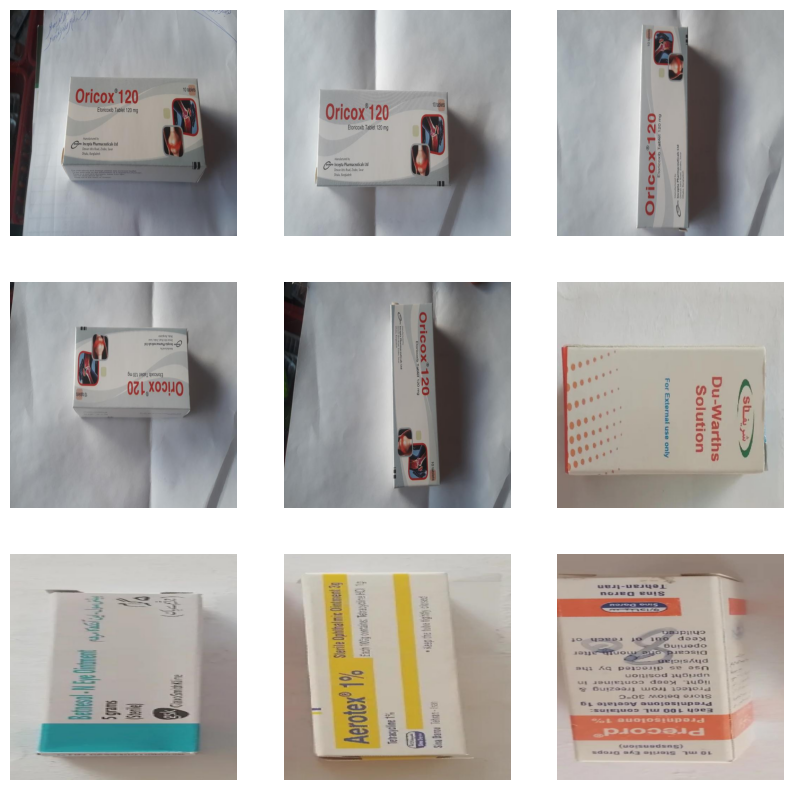

In [2]:
# Unzipping and Loading the Dataset
zip_file_path = 'Drug-Name.zip'
dataset_path = './Drug-Name/'

if not os.path.exists(dataset_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print(f"Unzipped the dataset to: {dataset_path}")
else:
    print(f"Dataset already extracted at: {dataset_path}")

# Load the data.yaml for paths and configuration
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

if os.path.exists(yaml_file_path):
    with open(yaml_file_path, 'r') as file:
        data_config = yaml.safe_load(file)
    print("Contents of data.yaml:")
    print(data_config)
else:
    print("Error: data.yaml file not found.")

# Paths to the image directories
train_dir = os.path.join(dataset_path, 'train', 'images')
train_images = glob(os.path.join(train_dir, "*.jpg"))  # Assuming images are in jpg format
print(f"Number of training images: {len(train_images)}")

# Display a few sample images to understand the data
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(train_images[:9]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Tesseract Extracted Text: SSS
i
se
CSvUriistee

[2024/11/11 11:55:28] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\milto/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\milto/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=Tr

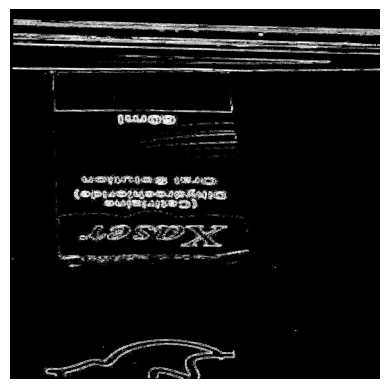

In [3]:
# Preprocessing function (improves image for OCR)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from path: {image_path}")
        return None

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize for better clarity in OCR (upscale for small text)
    resized_img = cv2.resize(gray_img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)

    # Sharpen the image using Laplacian filter
    laplacian_sharpened = cv2.Laplacian(blurred_img, cv2.CV_64F)
    sharpened_img = cv2.convertScaleAbs(laplacian_sharpened)

    # Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(sharpened_img)

    # Otsu's Binarization
    _, otsu_thresh_img = cv2.threshold(clahe_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Rotation correction (optional)
    edges = cv2.Canny(otsu_thresh_img, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    
    if lines is not None:
        angle = np.mean([np.arctan2(y2 - y1, x2 - x1) for x1, y1, x2, y2 in lines[:, 0]])
        angle = np.degrees(angle)
        (h, w) = otsu_thresh_img.shape
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(otsu_thresh_img, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)
    else:
        rotated_img = otsu_thresh_img

    return rotated_img

# OCR Models

# Tesseract OCR
def extract_text_with_tesseract(image_path):
    preprocessed_img = preprocess_image(image_path)
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    extracted_text = pytesseract.image_to_string(preprocessed_img, config=custom_config)
    return extracted_text

# PaddleOCR (CRNN)
def extract_text_with_crnn(image_path):
    ocr_model = PaddleOCR(use_angle_cls=True, lang='en')
    result = ocr_model.ocr(image_path, cls=True)
    extracted_text = " ".join([line[1][0] for line in result[0]])
    return extracted_text

# Fuzzy Matching
def fuzzy_match(extracted_text, target_text="Xanser (Cetirizine Dihydrochloride) Oral Solution 60ml"):
    similarity = fuzz.ratio(extracted_text.lower(), target_text.lower())
    return similarity

# Example Image and Target Text
image_path = '8EOCEZeEqgWQdDIsEkYWKzVgiTd_jpg.rf.60114629253e31a5422925f7eb40d0ef.jpg'
target_text = "Xanser (Cetirizine Dihydrochloride) Oral Solution 60ml"

# Get extracted text from OCR models
tesseract_text = extract_text_with_tesseract(image_path)
print(f"Tesseract Extracted Text: {tesseract_text}")
crnn_text = extract_text_with_crnn(image_path)
print(f"PaddleOCR (CRNN) Extracted Text: {crnn_text}")

# Fuzzy Matching Results
fuzzy_match_tesseract = fuzzy_match(extracted_text=tesseract_text, target_text=target_text)
fuzzy_match_crnn = fuzzy_match(extracted_text=crnn_text, target_text=target_text)

print(f"Fuzzy Matching Similarity (Tesseract): {fuzzy_match_tesseract}%")
print(f"Fuzzy Matching Similarity (CRNN): {fuzzy_match_crnn}%")

# Display preprocessed image (optional)
processed_image = preprocess_image(image_path)
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.show()


In [4]:
# Evaluate the OCR Results
def evaluate_model(ground_truth, extracted_text):
    """
    Evaluates the OCR performance using different metrics.
    :param ground_truth: The expected (correct) text.
    :param extracted_text: The text extracted by the OCR model.
    :return: A dictionary containing evaluation metrics: fuzzy similarity, character accuracy, and word error rate.
    """
    # Fuzzy Similarity Score (measures the overall match between strings)
    similarity = fuzz.ratio(ground_truth.lower(), extracted_text.lower())
    
    # Character Accuracy (measures character-level match)
    matcher = SequenceMatcher(None, ground_truth, extracted_text)
    character_accuracy = matcher.ratio() * 100
    
    # Word Error Rate (measures word-level accuracy)
    word_error_rate = jiwer.wer(ground_truth, extracted_text)
    
    return {
        "fuzzy_similarity": similarity,
        "character_accuracy": character_accuracy,
        "word_error_rate": word_error_rate
    }

# Example evaluation
ground_truth = "Xanser (Cetirizine Dihydrochloride) Oral Solution 60ml"
extracted_text = "Xaser (Cetririzine Dihydrochloride) Oral Solution 60ml"  # Example output from OCR

evaluation_results = evaluate_model(ground_truth, extracted_text)

print(f"Evaluation Results: {evaluation_results}")

Evaluation Results: {'fuzzy_similarity': 98, 'character_accuracy': 98.14814814814815, 'word_error_rate': 0.3333333333333333}


In [5]:
# Interpretation

# These results suggest that while the fuzzy similarity shows some degree of closeness to the actual drug name, 
# the detection is still quite inaccurate overall. 
# The low character accuracy and high word error rate indicate that the OCR model struggled to detect the drug name correctly.

# Possible Next Steps:

# Improving Preprocessing: You could try different preprocessing techniques such as more advanced noise reduction, adaptive thresholding, or rotation correction to improve the OCR performance.
# Custom Training or Fine-tuning: If this dataset is crucial, you might consider training or fine-tuning a model specifically for recognizing drug names, possibly using a labeled dataset.
# Post-Processing Heuristics: Implementing better post-processing, such as dictionary lookups for common drug names, could help improve the accuracy of the recognized names.